# RNA velocity

Instructions on how to generate the `.loom` files can be found in the documentation of [velocyto](http://velocyto.org/). Another option to do this is using [alevin](https://combine-lab.github.io/alevin-tutorial/2020/alevin-velocity/). We will analyze the data of Glutamaergic differentiation from the original publication of [RNA velocity](https://www.nature.com/articles/s41586-018-0414-6).

## Settings

In [2]:
import scvelo as scv
import loompy as lp
import pandas as pd
import numpy as np
import umap
import scanpy
from matplotlib import pyplot as plt
import pickle
from matplotlib import colors

In [3]:
scv.logging.print_version()
scv.settings.verbosity = 0  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.3 (python 3.8.8) on 2021-03-29 11:38.


## Preprocessing

In [69]:
adata = scv.read("../../data/loom/a4.hgForebrainGlut.loom", cache=True)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


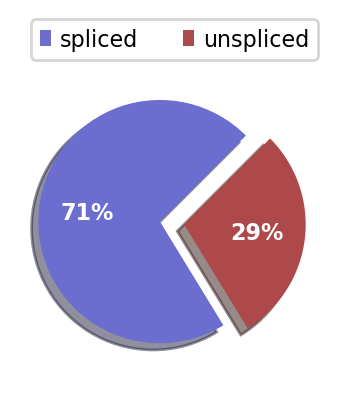

In [70]:
scv.pl.proportions(adata)

In [71]:
scv.pp.filter_and_normalize(adata,min_counts=10,min_cells=30,n_top_genes=2000)
scv.pp.neighbors(adata, n_pcs=20, n_neighbors=30)
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)
adata

AnnData object with n_obs × n_vars = 1720 × 2000
    obs: 'Clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

## Dimensionality reduction and embbedding

In [72]:
scanpy.tl.leiden(adata,0.5)
scv.tl.umap(adata,min_dist=1)

## Estimations

### RNA velocity

In [73]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical',use_highly_variable=True)

  0%|          | 0/903 [00:00<?, ?gene/s]

### Latent time

In [77]:
scv.tl.recover_latent_time(adata)
scv.tl.terminal_states(adata)

### Downstream analysis

In [78]:
scv.tl.velocity_confidence(adata)
scv.tl.score_genes_cell_cycle(adata)
scv.tl.rank_velocity_genes(adata, groupby='leiden',n_genes=300)

## Visualizations

**Velocity embeddings**

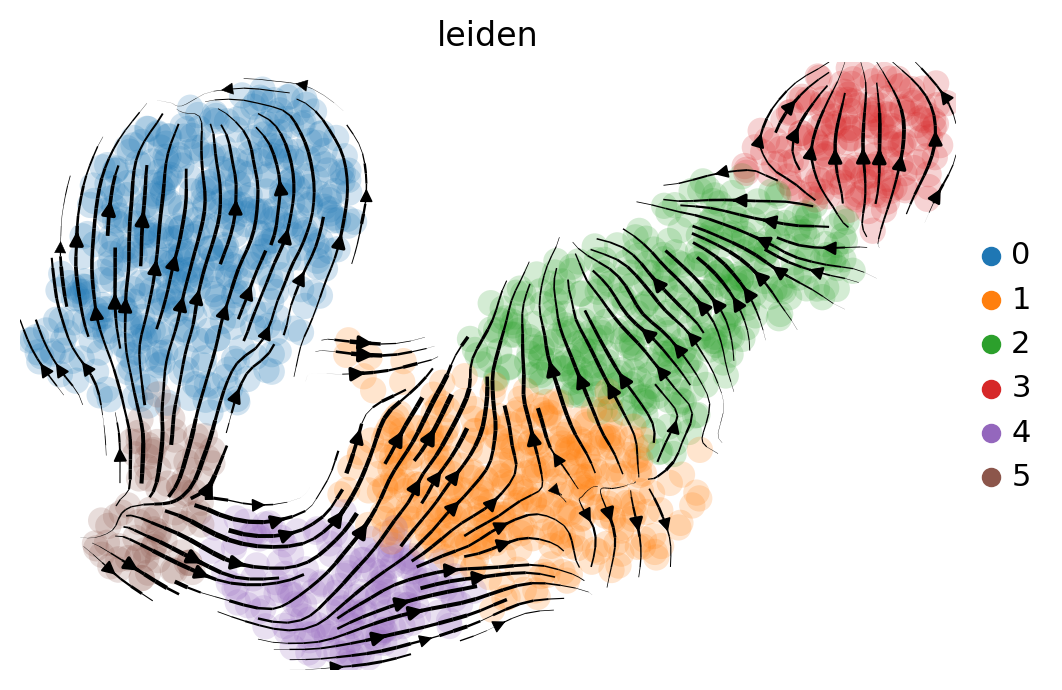

In [79]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='leiden',legend_loc='right',n_neighbors=200,recompute=True,alpha=0.2)

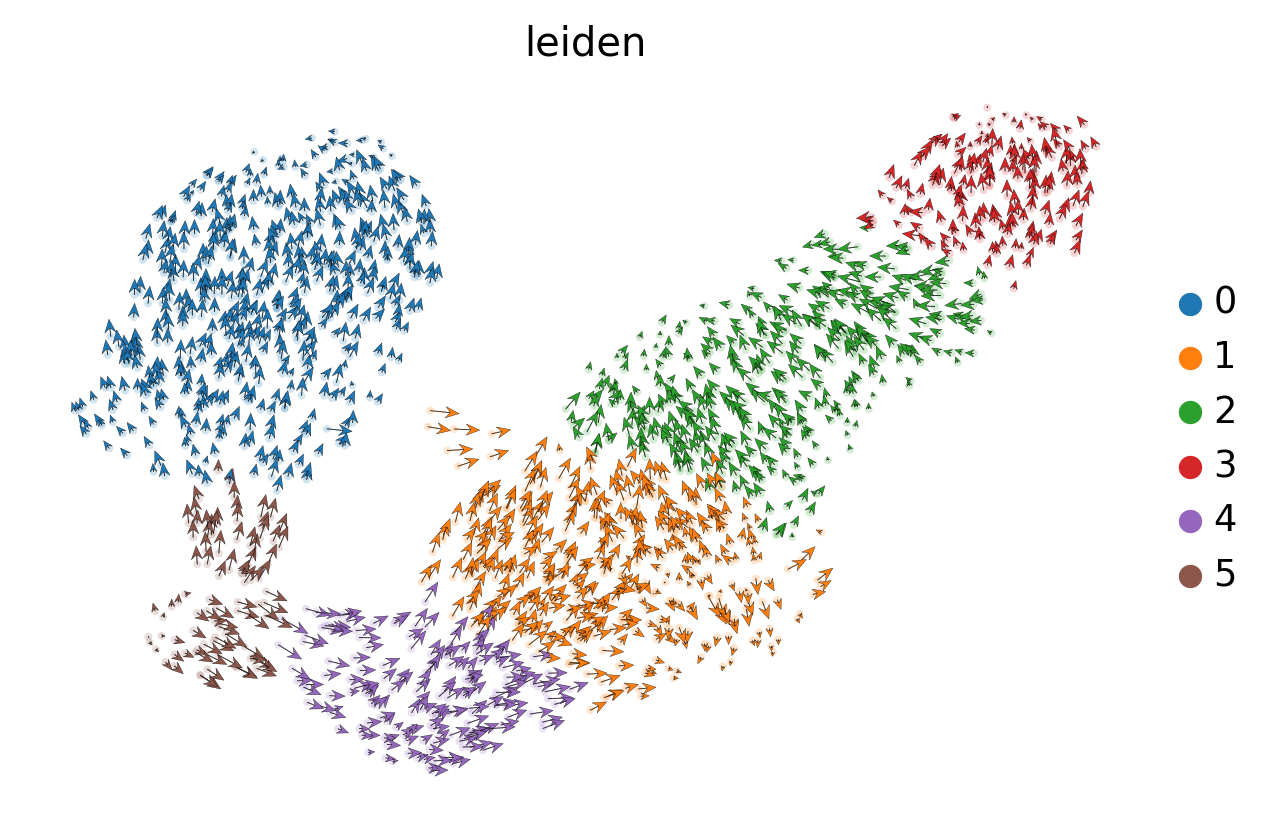

In [80]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120,color='leiden',legend_loc='right')

**Velocity confidence**

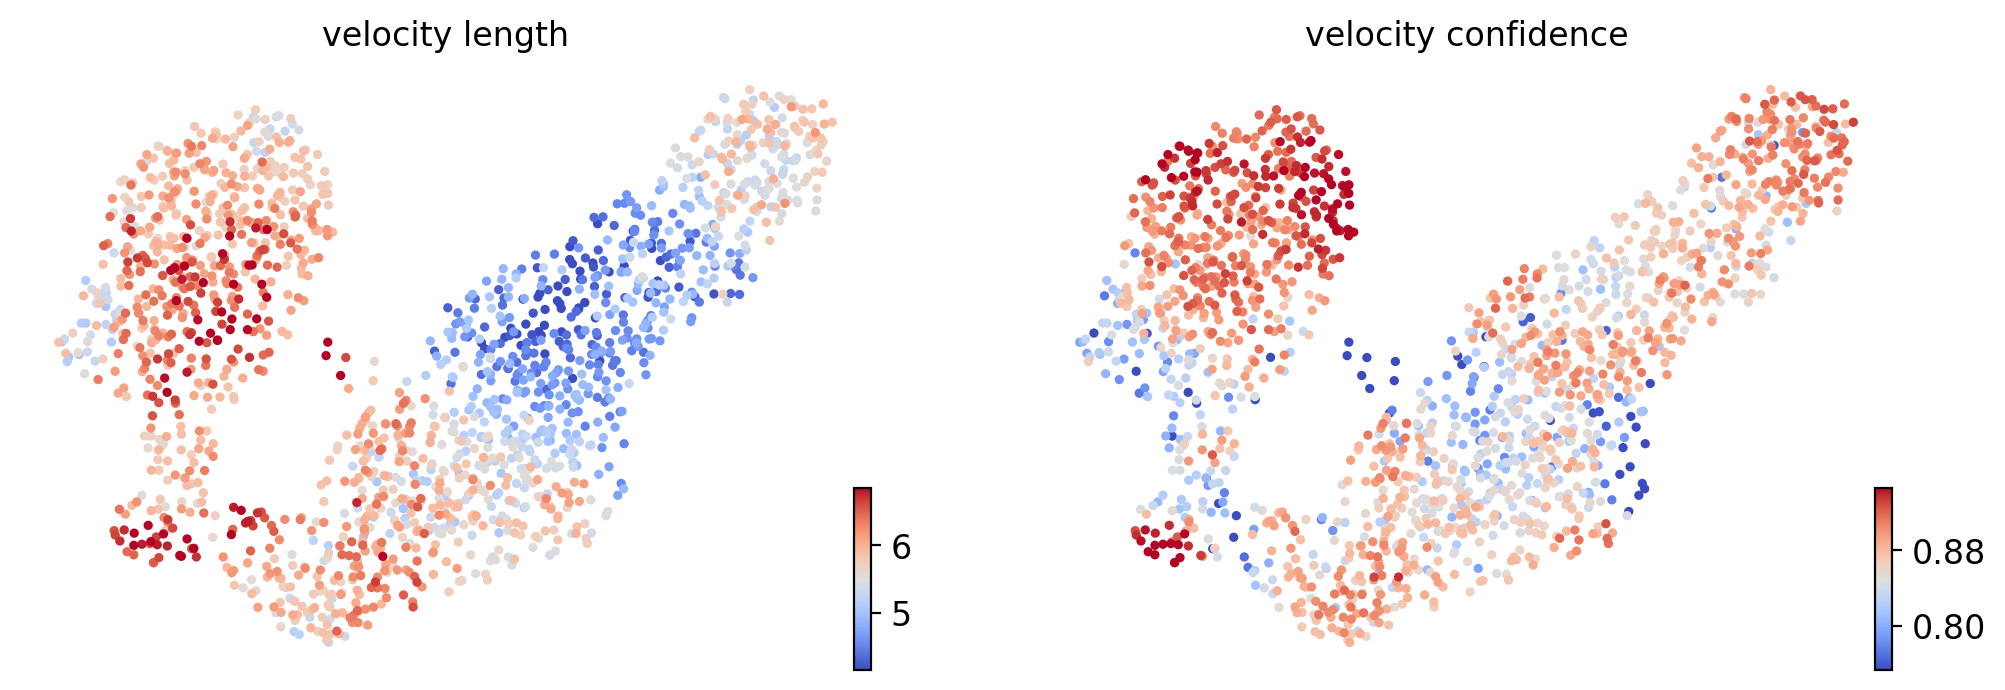

In [81]:
scv.tl.velocity_confidence(adata)
tags = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=tags, cmap='coolwarm', perc=[2, 98])

**Cell cycle scores**

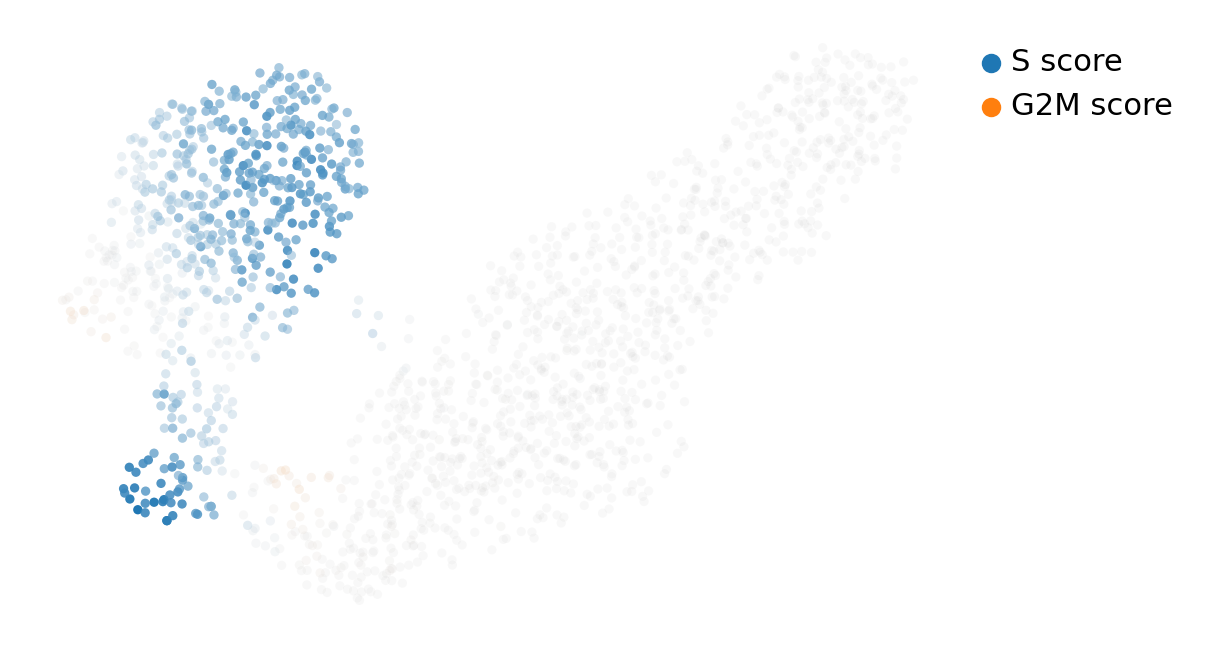

In [82]:
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

**Pseudotime analysis**

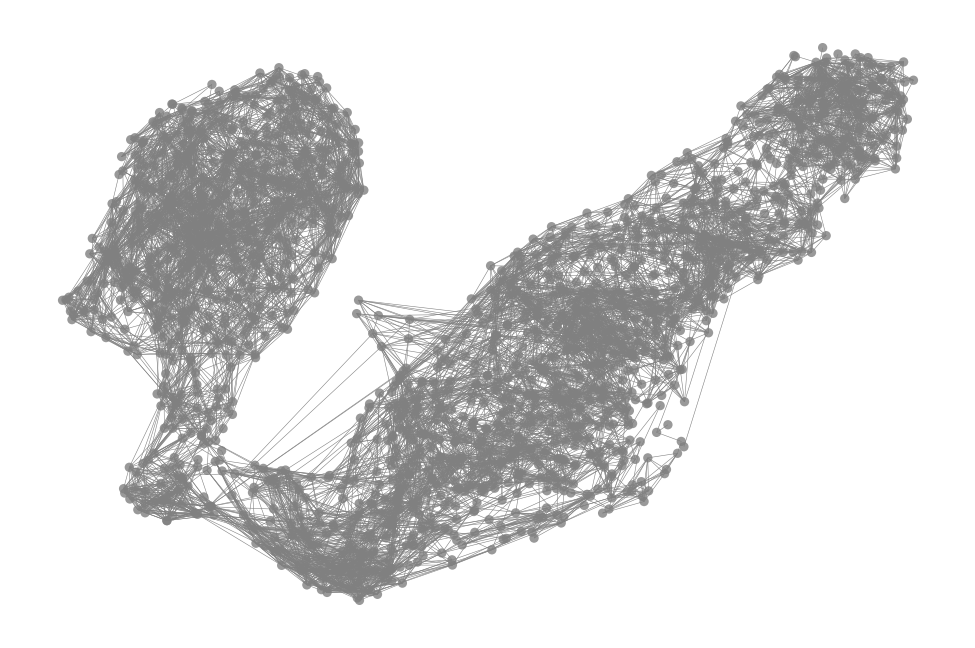

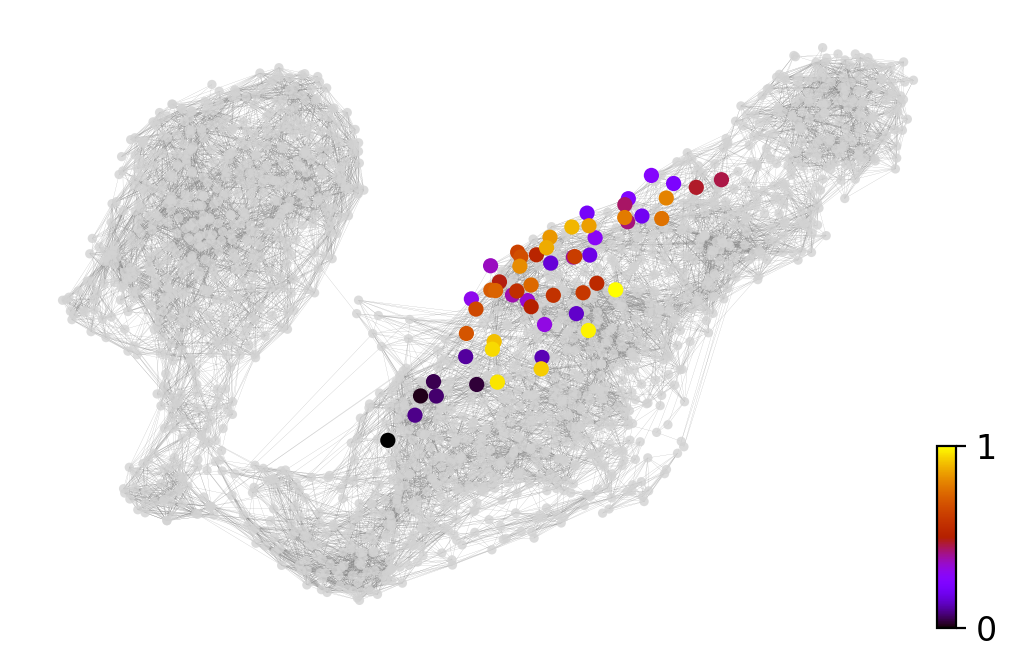

In [83]:
scv.pl.velocity_graph(adata, threshold=.1)
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

**Velocity graph**

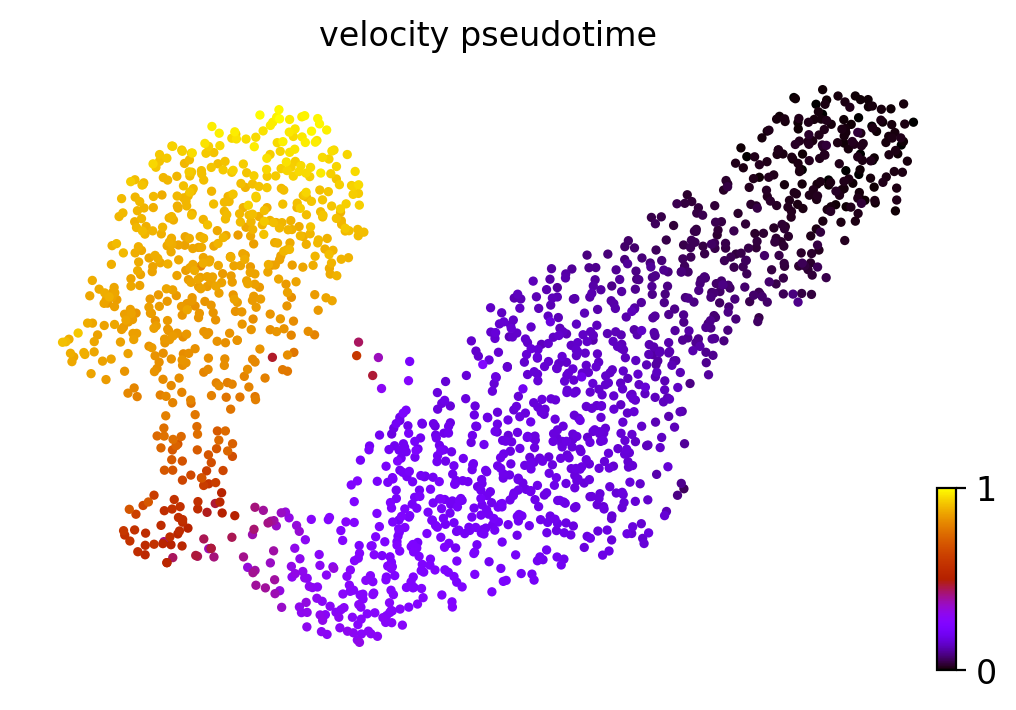

In [84]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

### Trajectory inference

In [65]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='leiden')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

,0,1,2,3,4
0,0,0,0.7,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0.24,0,0
4,0.15,0.28,0,0,0


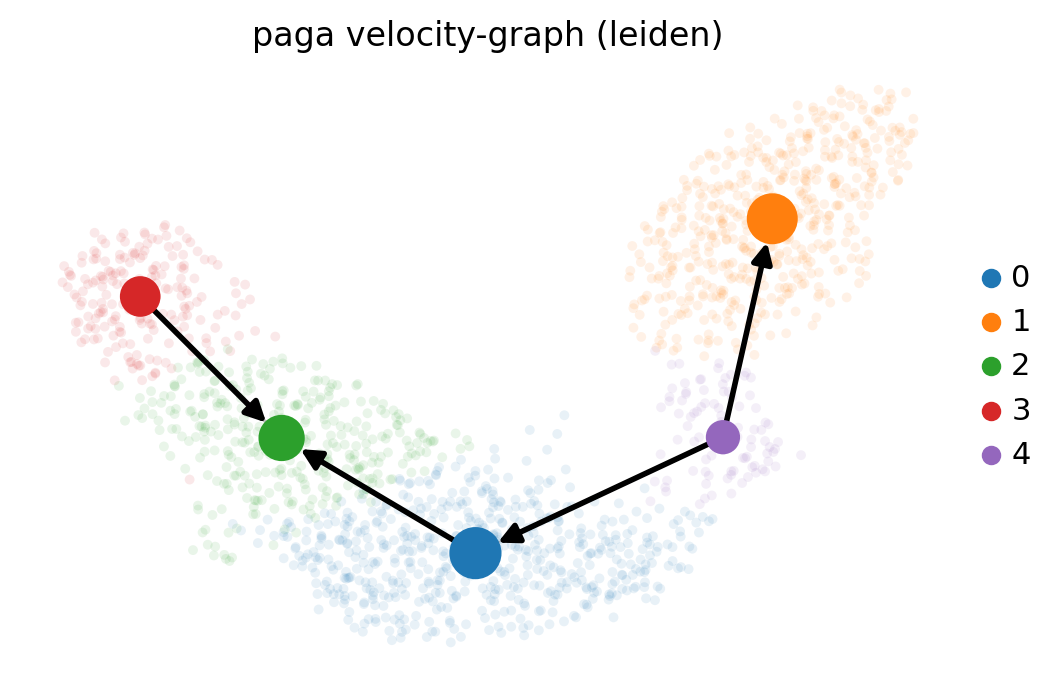

In [66]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

### Hands-on activity 3

---

1. How many genes have valid estimates of RNA velocity?
2. What happens if you change the model to `deterministic`?